<h1>
MNIST with CNN
</h1>

<div style="text-align: right;">
<h4>
박주형 연구원의 Optical character recognition; OCR 코드를 참고하였습니다.
</h4>
</div>

---

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix 

/home/hufs/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/hufs/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


---

## Data set

In [3]:
x_train = mnist.train.images
x_test = mnist.test.images

In [4]:
y_train = mnist.train.labels
y_test = mnist.test.labels

In [5]:
label_train = np.argmax(y_train, axis=1)
label_test = np.argmax(y_test, axis=1)

In [6]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [7]:
label_train

array([7, 3, 4, ..., 5, 6, 8])

In [8]:
img_size = 28  # MNIST data size 28*28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

In [9]:
x_train.shape

(55000, 784)

In [10]:
label_train.shape

(55000,)

---

In [11]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

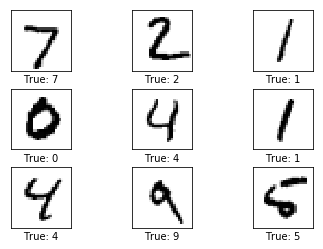

In [12]:
plot_images(images=x_test[:9],
            cls_true=label_test[:9])

---

## Build a model

In [13]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x" :  np.array(x_train)},
    y=np.array(label_train),
    num_epochs=None,
    shuffle=True)

In [14]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": np.array(x_test)},
    y=np.array(label_test),
    num_epochs=1,
    shuffle=False)

In [15]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True 
sess = tf.Session(config=config)

In [16]:
def conv2d(x, name, filters):
    return tf.layers.conv2d(
        inputs=x,
        name=name,
        filters=filters, 
        kernel_size=3,
        padding="same",
        activation=tf.nn.elu,
        reuse=tf.AUTO_REUSE# whether to reuse the weights of a previous layer by the same name.
    )

In [17]:
def mp2d(x):
    return tf.layers.max_pooling2d(
        inputs=x,
        pool_size=2,
        strides=2)

In [18]:
def dense(x, name, node, activation):
    return tf.layers.dense(
        inputs=x,
        name=name,
        units=node, #dimensionality of the output space.
        activation=activation,
        reuse=tf.AUTO_REUSE)

In [19]:
def dropout(x, rate, training):
    return tf.layers.dropout(
        inputs=x,
        rate=rate,
        training=training)

In [20]:
def vgg(x, training):
    
    net = tf.reshape(x, [-1, img_size, img_size, num_channels])
    net = tf.image.resize_image_with_crop_or_pad(net, 48, 48)
    
    net = conv2d(net, 'layers_conv1', 32)
    net = conv2d(net, 'layers_conv2', 32)
    net = mp2d(net)                      # 48 --> 24
    net = conv2d(net, 'layers_conv3', 64)
    net = conv2d(net, 'layers_conv4', 64)
    net = mp2d(net)                      # 24 --> 12
    net = conv2d(net, 'layers_conv5', 128)
    net = conv2d(net, 'layers_conv6', 128)
    net = mp2d(net)                      # 12 --> 6
    
    net = tf.contrib.layers.flatten(net)
    
    fc = dense(net, 'layers_fc1', num_classes*2, tf.nn.elu)
    fc = dropout(fc, 0.5, training=training)
    fc = dense(fc, 'layers_fc2', num_classes*2, tf.nn.elu)
    fc = dropout(fc, 0.5, training=training)
    
    fc = dense(fc, 'softmax', num_classes, None)
    
    return fc

In [21]:
def model_fn(features, labels, mode, params):
    
    x = features["x"]

    net_train = vgg(x, training=True)
    net_test = vgg(x, training=False)
    
    y_pred = tf.nn.softmax(logits=net_test)    
    y_pred_cls = tf.argmax(y_pred, axis=1)

    
    if mode == tf.estimator.ModeKeys.PREDICT:
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred_cls)
        
    else:        
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=net_train)   
        loss = tf.reduce_mean(cross_entropy)
        tf.summary.scalar("loss", loss)
        
        
        optimizer = tf.train.AdamOptimizer(learning_rate=params["learning_rate"])
       
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())
        
        acc = tf.metrics.accuracy(labels, y_pred_cls)
        
        logging_hook = tf.train.LoggingTensorHook(
            {
                "my_loss" : loss,
                "my_step" : tf.train.get_global_step(),
            },
            every_n_iter=10000)
         
        summary_hook = tf.train.SummarySaverHook(
            save_secs=60,
            output_dir='./logs/tf',
            summary_op=tf.summary.merge_all())
         
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops={"accuracy": acc},
            training_hooks=[logging_hook, summary_hook]
        )
        
    return spec

In [22]:
params = {
    "learning_rate": 5e-5
}

---

## Train, evaluate, and predict

In [23]:
run_config = tf.estimator.RunConfig(session_config=config,
                                    save_summary_steps=100,
                                    keep_checkpoint_max=3,
                                    keep_checkpoint_every_n_hours=1,
                                    log_step_count_steps=10000)

In [24]:
# Estimators 
model =tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               config=run_config,
                               model_dir="./MNIST_sy/")

INFO:tensorflow:Using config: {'_model_dir': './MNIST_sy/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  allow_growth: true
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 1, '_log_step_count_steps': 10000, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f66c8bf14a8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<span style="color:#D74B4B; font-size:x-large; font-weight:bolder;"> 
Training
</span>

In [22]:
model.train(input_fn=train_input_fn, steps=10000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./MNIST_sy/model.ckpt.
INFO:tensorflow:loss = 2.3031788, step = 1
INFO:tensorflow:my_loss = 2.3031788, my_step = 1
INFO:tensorflow:loss = 1.8482804, step = 101 (139.180 sec)
INFO:tensorflow:loss = 1.3891673, step = 201 (144.196 sec)
INFO:tensorflow:loss = 1.3165405, step = 301 (143.630 sec)
INFO:tensorflow:loss = 1.166844, step = 401 (140.577 sec)
INFO:tensorflow:Saving checkpoints for 425 into ./MNIST_sy/model.ckpt.
INFO:tensorflow:loss = 1.0809393, step = 501 (139.642 sec)
INFO:tensorflow:loss = 1.1953316, step = 601 (136.806 sec)
INFO:tensorflow:loss = 1.1496679, step = 701 (133.803 sec)
INFO:tensorflow:loss = 0.9436778, step = 801 (133.338 sec)
INFO:tensorflow:Saving checkpoints for 867 into ./MNIST_sy/model.ckpt.
INFO:tensorflow:loss = 0.9474902, step = 901 (134.872 sec)
INFO:tensorflow:loss = 0.92214566, step = 1001 (133.927 sec)
INFO:tensorflow:loss = 0.7751651, step = 1101 (134.541 sec)
IN

<span style="color:#D74B4B; font-size:x-large; font-weight:bolder;"> 
Evaluation
</span>

Train : 55,000    
Test  : 10,000

In [23]:
result = model.evaluate(input_fn=test_input_fn) 

INFO:tensorflow:Starting evaluation at 2018-02-07-07:03:34
INFO:tensorflow:Restoring parameters from ./MNIST_sy/model.ckpt-10000
INFO:tensorflow:Finished evaluation at 2018-02-07-07:04:49
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.9899, global_step = 10000, loss = 0.31213006


In [24]:
result

{'accuracy': 0.9899, 'global_step': 10000, 'loss': 0.31213006}

In [25]:
print("Classification accuracy: {0:.5%}".format(result["accuracy"]))

Classification accuracy: 98.99000%


<span style="color:#D74B4B; font-size:x-large; font-weight:bolder;"> 
Prediction
</span>

In [33]:
predictions = model.predict(input_fn=test_input_fn)

In [34]:
cls_pred = np.array(list(predictions))
cls_pred

INFO:tensorflow:Restoring parameters from ./MNIST_sy/model.ckpt-10000


array([7, 2, 1, ..., 4, 5, 6])

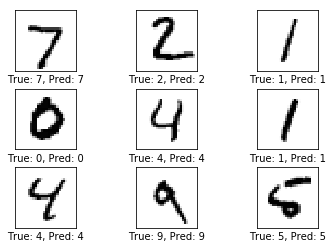

In [35]:
plot_images(images=x_test[:9],
            cls_true=label_test[:9],
            cls_pred=cls_pred[:9])